In [ ]:
!pip install torch torchvision albumentations==1.3.0 opencv-python tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [37]:
import os
import cv2
import json
import random
import numpy as np
from tqdm import tqdm
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Augmentations for training
train_aug = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.GaussianBlur(blur_limit=3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
])

# Simple procedural map generator
def generate_random_map(size=128, rooms=5, room_max=30, room_min=10):
    mask = np.zeros((size, size), np.uint8)
    for _ in range(rooms):
        w = random.randint(room_min, room_max)
        h = random.randint(room_min, room_max)
        x = random.randint(0, size - w - 1)
        y = random.randint(0, size - h - 1)
        mask[y:y+h, x:x+w] = 255
    # draw simple corridors
    # connect center of each room in sequence
    centers = []
    # find each room bounding box center
    # (we approximate by sampling some white pixels clusters)
    pts = cv2.findNonZero(mask)
    if pts is not None:
        # skip detailed; corridor generation is minimal
        pass
    return mask


/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [29]:
# ─── Cell: Improved Synthetic Map + Mask Generator ──────────────────────────

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def generate_connected_map(img_size=128,
                           room_count=5,
                           room_min=10, room_max=30,
                           corridor_width=3):
    """
    Returns (map_img, mask_img), where:
      - map_img: RGB with white rooms/corridors on black
      - mask_img: single‐channel binary mask
    """
    rooms = []
    mask = np.zeros((img_size, img_size), dtype=np.uint8)

    # 1) Place random non‐overlapping rooms
    for _ in range(room_count):
        for _ in range(100):  # try up to 100 times
            w, h = np.random.randint(room_min, room_max, 2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            new_room = np.array([x, y, x+w, y+h])
            # check overlap
            if all(not (new_room[0] < r[2] and new_room[2] > r[0]
                       and new_room[1] < r[3] and new_room[3] > r[1])
                   for r in rooms):
                rooms.append(new_room)
                cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
                break

    # 2) Compute room centers & connect them in a random spanning tree
    centers = [((r[0]+r[2])//2, (r[1]+r[3])//2) for r in rooms]
    # build a minimal spanning tree by randomly linking nearest neighbors
    unused = centers.copy()
    used = [unused.pop(0)]
    while unused:
        # find closest pair (u in used, v in unused)
        dists = [(np.hypot(u[0]-v[0], u[1]-v[1]), u, v)
                 for u in used for v in unused]
        _, u, v = min(dists, key=lambda x: x[0])
        # draw corridor: horizontal then vertical line
        cv2.line(mask, u, (v[0], u[1]), 255, corridor_width)
        cv2.line(mask, (v[0], u[1]), v, 255, corridor_width)
        used.append(v)
        unused.remove(v)

    # final images
    map_img  = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    return map_img, mask

import torch
import torchvision.transforms.functional as TF
from torch.utils.data import TensorDataset, random_split, DataLoader

# 1) Generate 500 maps+ masks in‐memory
NUM_SAMPLES = 500
maps, masks = zip(*(generate_connected_map() for _ in range(NUM_SAMPLES)))

# 2) Convert to float Tensors & permute channels to (C,H,W)
maps_t  = torch.stack([TF.to_tensor(img)  for img in maps ])  # (500,3,H,W)
masks_t = torch.stack([TF.to_tensor(mask) for mask in masks])  # (500,1,H,W)

# 3) Build TensorDataset and split 80/20
full_ds = TensorDataset(maps_t, masks_t)
val_n   = int(0.2 * len(full_ds))
train_ds, val_ds = random_split(full_ds, [len(full_ds)-val_n, val_n])

# 4) Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False)

print(f"train samples: {len(train_ds)}, val samples: {len(val_ds)}")
print(f"batches/train: {len(train_loader)}, batches/val: {len(val_loader)}")


train samples: 400, val samples: 100
batches/train: 25, batches/val: 7


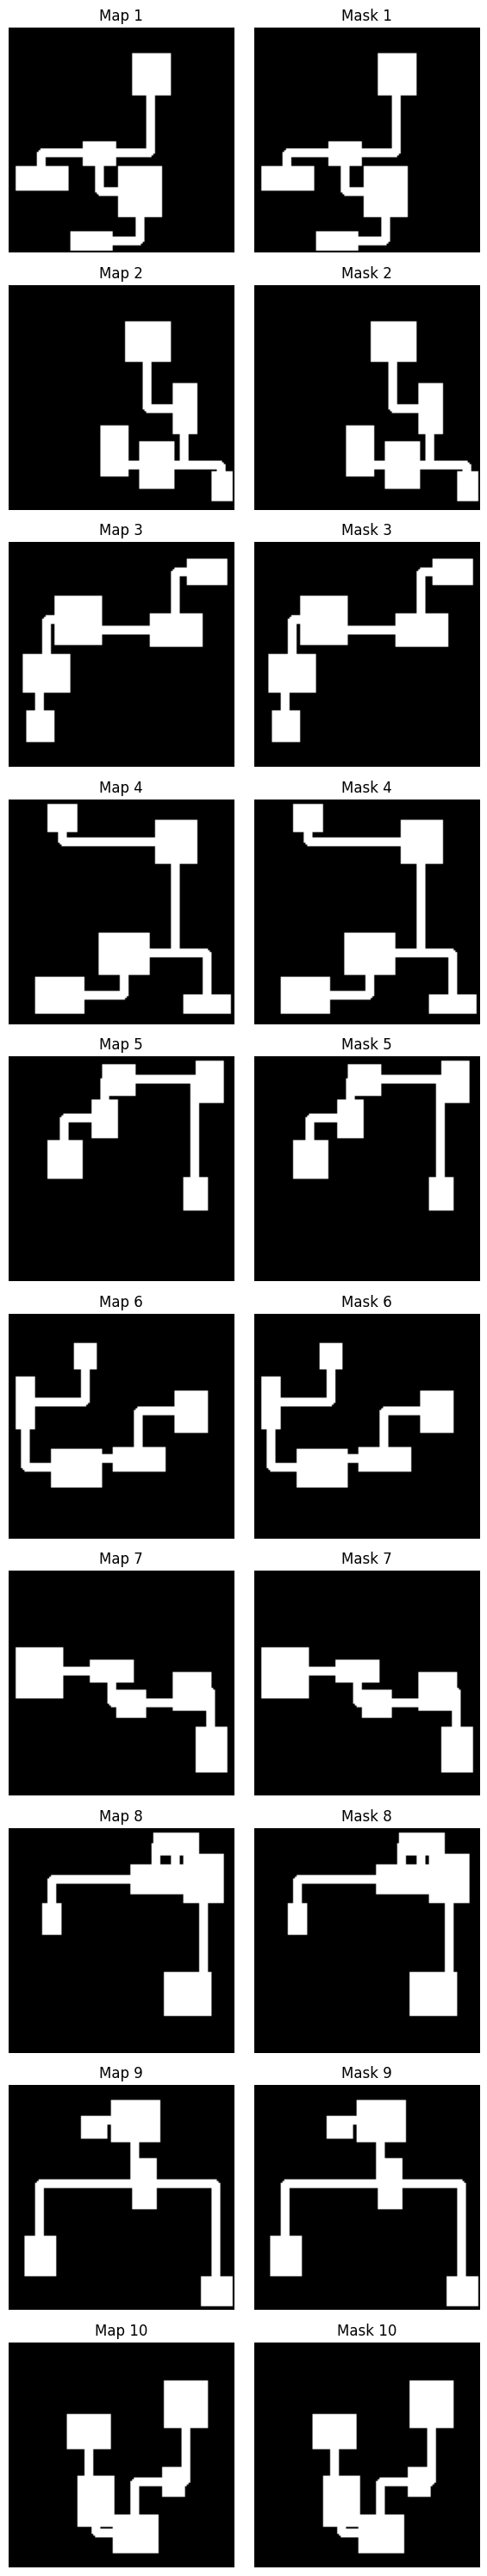

In [31]:
# but only preview the first 10:
fig, axes = plt.subplots(10, 2, figsize=(6, 30))
for i, (m, mk) in enumerate(examples[:10]):
    axes[i,0].imshow(m)
    axes[i,0].set_title(f"Map {i+1}")
    axes[i,0].axis('off')
    axes[i,1].imshow(mk, cmap='gray')
    axes[i,1].set_title(f"Mask {i+1}")
    axes[i,1].axis('off')
plt.tight_layout()
plt.show()

In [32]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def C(in_f, out_f): return nn.Sequential(
            nn.Conv2d(in_f,out_f,3,padding=1), nn.ReLU(), nn.Conv2d(out_f,out_f,3,padding=1), nn.ReLU())
        self.enc1 = C(3,64); self.pool = nn.MaxPool2d(2)
        self.enc2 = C(64,128)
        self.enc3 = C(128,256)
        self.enc4 = C(256,512)
        self.bottleneck = C(512,1024)
        def up(in_f, out_f): return nn.ConvTranspose2d(in_f,out_f,2,stride=2)
        self.up4 = up(1024,512); self.dec4 = C(1024,512)
        self.up3 = up(512,256);  self.dec3 = C(512,256)
        self.up2 = up(256,128);  self.dec2 = C(256,128)
        self.up1 = up(128,64);   self.dec1 = C(128,64)
        self.final = nn.Conv2d(64,1,1)

    def forward(self,x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2)); e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4],1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3],1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2],1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1],1))
        return torch.sigmoid(self.final(d1))


In [33]:
print("  ▶️  # train samples:", len(train_ds))
print("  ▶️  # val   samples:", len(val_ds))
print("  ▶️  batches/train:", len(train_loader))
print("  ▶️  batches/val:  ", len(val_loader))


  ▶️  # train samples: 400
  ▶️  # val   samples: 100
  ▶️  batches/train: 25
  ▶️  batches/val:   7


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1. Hyperparameters
BATCH_SIZE = 16      # ← pick something << len(train_ds)
EPOCHS     = 10      # ↑ you can increase this if you want more training
LR         = 1e-3

# 2. DataLoaders
train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)
val_loader   = DataLoader(val_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=2,
                          pin_memory=True)

# 3. Model, optimizer, loss
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model    = UNet().to(device)
opt      = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss()

# 4. Training + validation loop
for epoch in range(1, EPOCHS+1):
    # ——— Training ———
    model.train()
    train_pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{EPOCHS}")
    total_train_loss = 0.0

    for imgs, masks in train_pbar:
        imgs, masks = imgs.to(device), masks.to(device)

        # forward + backward + optimize
        preds = model(imgs)
        loss  = criterion(preds, masks)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()
        train_pbar.set_postfix(train_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)

    # ——— Validation ———
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss  = criterion(preds, masks)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # 5. Print epoch summary
    print(f"Epoch {epoch}/{EPOCHS} → "
          f"Train Loss: {avg_train_loss:.4f}  |  "
          f"Val Loss:   {avg_val_loss:.4f}")


[Train] Epoch 1/10: 100%|██████████| 25/25 [10:10<00:00, 24.42s/it, train_loss=0.0815]


Epoch 1/10 → Train Loss: 0.4596  |  Val Loss:   0.0644


[Train] Epoch 2/10: 100%|██████████| 25/25 [10:03<00:00, 24.16s/it, train_loss=0.00746]


Epoch 2/10 → Train Loss: 0.0166  |  Val Loss:   0.0073


[Train] Epoch 3/10: 100%|██████████| 25/25 [10:03<00:00, 24.15s/it, train_loss=0.0121]


Epoch 3/10 → Train Loss: 0.3693  |  Val Loss:   0.0106


[Train] Epoch 4/10: 100%|██████████| 25/25 [09:51<00:00, 23.66s/it, train_loss=0.00497]


Epoch 4/10 → Train Loss: 0.0162  |  Val Loss:   0.0052


[Train] Epoch 5/10: 100%|██████████| 25/25 [09:53<00:00, 23.72s/it, train_loss=0.00263]


Epoch 5/10 → Train Loss: 0.0038  |  Val Loss:   0.0024


[Train] Epoch 6/10: 100%|██████████| 25/25 [10:01<00:00, 24.05s/it, train_loss=0.00131]


Epoch 6/10 → Train Loss: 0.0015  |  Val Loss:   0.0010


[Train] Epoch 7/10: 100%|██████████| 25/25 [10:05<00:00, 24.23s/it, train_loss=0.000518]


Epoch 7/10 → Train Loss: 0.0007  |  Val Loss:   0.0005


[Train] Epoch 8/10: 100%|██████████| 25/25 [09:58<00:00, 23.93s/it, train_loss=0.000236]


Epoch 8/10 → Train Loss: 0.0003  |  Val Loss:   0.0002


[Train] Epoch 9/10: 100%|██████████| 25/25 [10:12<00:00, 24.49s/it, train_loss=0.000146]


Epoch 9/10 → Train Loss: 0.0002  |  Val Loss:   0.0002


[Train] Epoch 10/10: 100%|██████████| 25/25 [09:59<00:00, 23.97s/it, train_loss=0.000118]


Epoch 10/10 → Train Loss: 0.0001  |  Val Loss:   0.0001


In [41]:
drive.mount("/content/drive", force_remount=True)

HANDDRAWN_PATH = '/content/drive/MyDrive/maps/Handdrawn_2.png'

Mounted at /content/drive


In [42]:
import os

print("Does the file exist? ", os.path.exists(HANDDRAWN_PATH))
assert os.path.exists(HANDDRAWN_PATH), f"Cannot find {HANDDRAWN_PATH}"


Does the file exist?  True


Hand-drawn PNG path: /content/drive/MyDrive/maps/Handdrawn_2.png


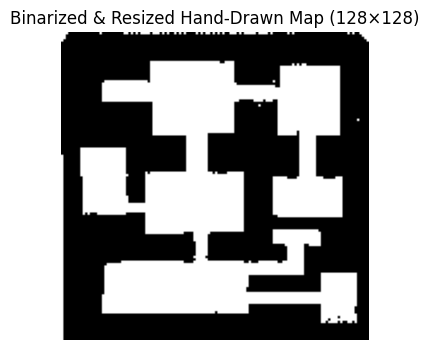

In [45]:
# ─── Cell 7a: Load, binarize, resize & display hand-drawn map ─────────────
import os
import cv2
import matplotlib.pyplot as plt

print("Hand-drawn PNG path:", HANDDRAWN_PATH)
assert os.path.exists(HANDDRAWN_PATH), "❌ Hand-drawn image not found!"

# 1) Load as grayscale
orig = cv2.imread(HANDDRAWN_PATH, cv2.IMREAD_GRAYSCALE)
if orig is None:
    raise RuntimeError(f"Could not load {HANDDRAWN_PATH}")

# 2) Binarize via Otsu
_, binary = cv2.threshold(orig, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3) Resize to SYN_SIZE × SYN_SIZE
resized_bin = cv2.resize(binary, (SYN_SIZE, SYN_SIZE),
                         interpolation=cv2.INTER_NEAREST)

# 4) Display
plt.figure(figsize=(4,4))
plt.title(f"Binarized & Resized Hand-Drawn Map ({SYN_SIZE}×{SYN_SIZE})")
plt.imshow(resized_bin, cmap='gray')
plt.axis('off')
plt.show()




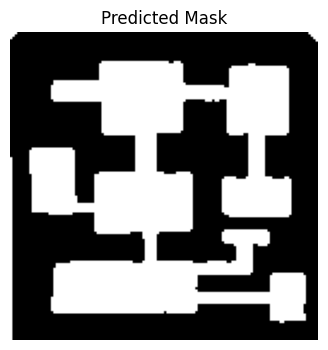

In [46]:
# ─── Cell 7b: Run U-Net on the pre-processed hand-drawn map ────────────────
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# 1) Convert binary image to 3-channel BGR
inp_bgr = cv2.cvtColor(resized_bin, cv2.COLOR_GRAY2BGR)

# 2) Build normalization + tensor transform (must match your training)
transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# 3) Apply transform & move to device
input_tensor = transform(image=inp_bgr)["image"].unsqueeze(0).to(device)

# 4) Inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)               # shape [1,1,SYN_SIZE,SYN_SIZE]
    probs  = torch.sigmoid(output).squeeze(0)  # [1,H,W] if your UNet outputs logits
    mask_pred = (probs.cpu().numpy()[0] > 0.5).astype(np.uint8) * 255

# 5) Preview the predicted mask
plt.figure(figsize=(4,4))
plt.title("Predicted Mask")
plt.imshow(mask_pred, cmap="gray")
plt.axis("off")
plt.show()



In [47]:
# ─── Cell 8: Extract coordinates from predicted mask & save JSON ─────────
import json

# 1) Gather all (x,y) where mask_pred is “wall” (255)
coords = []
H, W = mask_pred.shape
for y in range(H):
    for x in range(W):
        if mask_pred[y, x] == 255:
            coords.append([x, y])

# 2) Build JSON structure (same as Unity expects)
map_data = {
    "data": {
        "walls": coords
    }
}

# 3) Write to disk
out_path = "handdrawn_extracted_map.json"
with open(out_path, "w") as f:
    json.dump(map_data, f)

print(f"Saved {len(coords)} wall coords → {out_path}")


Saved 6600 wall coords → handdrawn_extracted_map.json


In [48]:
# Cell: Download JSON to local
from google.colab import files

files.download("handdrawn_extracted_map.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
# Cell: Package everything and download as ZIP
import os
from zipfile import ZipFile
from google.colab import files

# Paths—adjust if yours differ
model_path      = "segmentation_model.pth"
maps_folder     = "maps"
masks_folder    = "masks"
preview_input   = "preview_input.png"   # your saved binarized input
preview_mask    = "preview_mask.png"    # your saved preview mask

# Create the archive
zip_name = "deliverables.zip"
with ZipFile(zip_name, 'w') as zipf:
    # add model
    if os.path.exists(model_path):
        zipf.write(model_path)
    # add all maps and masks
    for folder in (maps_folder, masks_folder):
        if os.path.isdir(folder):
            for fname in os.listdir(folder):
                full = os.path.join(folder, fname)
                zipf.write(full, arcname=os.path.join(folder, fname))
    # add previews
    for fname in (preview_input, preview_mask):
        if os.path.exists(fname):
            zipf.write(fname)

# Download
files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# Cell: List all files in the workspace
import os

for root, dirs, files in os.walk('.'):
    # skip hidden folders
    if '/.' in root: continue
    print(f"\n{root}/")
    for f in files:
        print("  ", f)



./
   deliverables.zip
   predicted_mask.png
   handdrawn_extracted_map.json

./maps/
   map_336.png
   map_350.png
   map_491.png
   map_017.png
   map_033.png
   map_084.png
   map_019.png
   map_018.png
   map_120.png
   map_229.png
   map_169.png
   map_359.png
   map_128.png
   map_209.png
   map_383.png
   map_300.png
   map_468.png
   map_443.png
   map_315.png
   map_013.png
   map_365.png
   map_426.png
   map_076.png
   map_035.png
   map_042.png
   map_478.png
   map_154.png
   map_011.png
   map_066.png
   map_470.png
   map_367.png
   map_360.png
   map_445.png
   map_195.png
   map_056.png
   map_203.png
   map_335.png
   map_295.png
   map_248.png
   map_436.png
   map_262.png
   map_041.png
   map_001.png
   map_118.png
   map_355.png
   map_495.png
   map_064.png
   map_119.png
   map_144.png
   map_416.png
   map_485.png
   map_333.png
   map_292.png
   map_074.png
   map_304.png
   map_460.png
   map_447.png
   map_156.png
   map_150.png
   map_431.png
   map_402.pn

In [53]:
# Cell: Save trained model to disk
import torch

# assuming your model object is called `model`
torch.save(model.state_dict(), 'segmentation_model.pth')
print("Saved model → segmentation_model.pth")


Saved model → segmentation_model.pth


In [57]:
# Cell: Save preview input & mask
import cv2
import numpy as np

# 1) Save the binarized & resized hand-drawn input
# `resized_bin` is your binarized array (0 or 255), shape (SYN_SIZE, SYN_SIZE)
cv2.imwrite('preview_input.png', resized_bin)
print("Saved preview input → preview_input.png")

# 2) Save the predicted mask
# `mask_pred` is your model output, probably floats in [0,1], shape (1,1,H,W) or (H,W)
# First get it into a 2D uint8 0–255 image:
mp = mask_pred   # or just mask_pred if already numpy
mp_uint8 = (mp * 255).astype(np.uint8)
cv2.imwrite('preview_mask.png', mp_uint8)
print("Saved preview mask  → preview_mask.png")


Saved preview input → preview_input.png
Saved preview mask  → preview_mask.png


In [58]:
# Cell: Package everything and download as ZIP
import os
from zipfile import ZipFile
from google.colab import files

# Paths—adjust if yours differ
model_path      = "segmentation_model.pth"
preview_input   = "preview_input.png"   # your saved binarized input
preview_mask    = "predicted mask.png"   # your saved preview mask

# Create the archive
zip_name = "deliverables.zip"
with ZipFile(zip_name, 'w') as zipf:
    # add model
    if os.path.exists(model_path):
        zipf.write(model_path)
    # add all maps and masks
    for folder in (maps_folder, masks_folder):
        if os.path.isdir(folder):
            for fname in os.listdir(folder):
                full = os.path.join(folder, fname)
                zipf.write(full, arcname=os.path.join(folder, fname))
    # add previews
    for fname in (preview_input, preview_mask):
        if os.path.exists(fname):
            zipf.write(fname)

# Download
files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>